In [1]:
# Decides whether or not to include the language classifier portion of the notebook
# It takes a while to train
TRAIN_LANGUAGE_PREDICTOR = False
SENTIMENT_CLASSES = 3

In [2]:
import pandas as pd

In [3]:
l_raw = pd.read_excel("data/LData.xlsx", index_col='Unnamed: 0')
l_raw.head(1)

,app_name,user_id,user_name,date,country,version,score,topic,review,url,review_id,category_final,sentiment_final,req_final
52505.0,Facebook,246193109,Help is herr,2017-06-21 00:00:00,United States,97,1,Notifications not showing up,The notification badges are showing up on my i...,https://itunes.apple.com/WebObjects/MZStore.wo...,53163.0,requirement,neutral,functional


In [4]:
l_raw.info()
la = l_raw

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3000 entries, 52505.0 to 45413.0
Data columns (total 14 columns):
app_name           3000 non-null object
user_id            3000 non-null object
user_name          2993 non-null object
date               3000 non-null object
country            3000 non-null object
version            3000 non-null object
score              3000 non-null int64
topic              2994 non-null object
review             2996 non-null object
url                2850 non-null object
review_id          2850 non-null float64
category_final     3000 non-null object
sentiment_final    2796 non-null object
req_final          1081 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 351.6+ KB


# DATA CLEANING

* Reindex

In [5]:
la = la.reset_index(drop=True)
la.head()

,app_name,user_id,user_name,date,country,version,score,topic,review,url,review_id,category_final,sentiment_final,req_final
0,Facebook,246193109,Help is herr,2017-06-21 00:00:00,United States,97,1,Notifications not showing up,The notification badges are showing up on my i...,https://itunes.apple.com/WebObjects/MZStore.wo...,53163.0,requirement,neutral,functional
1,Facebook,43034279,javamdnss,2017-06-16 00:00:00,United States,97,1,Hate it!,Why do they make changes we don't need? Now th...,https://itunes.apple.com/WebObjects/MZStore.wo...,53905.0,other,very negative,NaN
2,Facebook,496978255,NaN,2017-05-27 00:00:00,Hong Kong,94,1,Useless function n poor experience,Story is useless n annoying to user. \nCan't s...,https://itunes.apple.com/WebObjects/MZStore.wo...,47401.0,other,negative,NaN
3,Facebook,139595037,Gilbertiggy,2017-05-26 00:00:00,United Kingdom,94,1,To many updates!,This app is always having an update for someth...,https://itunes.apple.com/WebObjects/MZStore.wo...,42233.0,requirement,negative,functional
4,Facebook,180832062,Princess Lou 24,2017-06-01 00:00:00,United Kingdom,94,1,Photo albums,Just spent an hour trying to upload photos and...,https://itunes.apple.com/WebObjects/MZStore.wo...,42066.0,requirement,negative,non-functional


* Drop unneccessary columns

In [6]:
la = la.drop(['user_id', 'url', 'review_id', 'version', 'user_name', 'app_name', 'date', 'req_final'], axis=1)
la.head(1)

,country,score,topic,review,category_final,sentiment_final
0,United States,1,Notifications not showing up,The notification badges are showing up on my i...,requirement,neutral


* Rename label columns

In [7]:
la = la.rename(columns = {
    "category_final": "category",
    "sentiment_final": "sentiment"
}, errors="raise")
la.head(1)

,country,score,topic,review,category,sentiment
0,United States,1,Notifications not showing up,The notification badges are showing up on my i...,requirement,neutral


* Remove NaN rows

In [8]:
# l = l[l['review'].notna()] # take the rows that are not NaN
la = la.dropna() # remove any row with at least one value missing NaN
la.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2795 entries, 0 to 2999
Data columns (total 6 columns):
country      2795 non-null object
score        2795 non-null int64
topic        2795 non-null object
review       2795 non-null object
category     2795 non-null object
sentiment    2795 non-null object
dtypes: int64(1), object(5)
memory usage: 152.9+ KB


In [9]:
# https://docs.python.org/2/library/string.html
import string
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

In [10]:
def remove_punctuation(data, column):
    """
    Uses string.punctuation list to remove unwarranted characeters
    !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    """
    punctuation_table = str.maketrans('', '', string.punctuation)
    stripped = [review.translate(punctuation_table) for review in data[column]]
    return stripped

def lowercase(data, column):
    review_arr = data[column].to_list()
    return [review.lower() for review in review_arr]

def asciionly(data, column):
    new_reviews = []
    for review in data[column]:
        review = re.sub('[^A-Za-z0-9\s]', '', review)
        new_reviews.append(review)
    return new_reviews

def new_line_to_space(data, column):
    new_reviews = []
    for review in data[column]:
        nr = review.replace('\n', ' ')
        nr = nr.replace('\t', '') # remove tab as well
        new_reviews.append(nr)
    return new_reviews

def remove_single_characters(data, column):
    new_reviews = []
    for review in data[column]:
        words = review.split(" ")
        new_words = []
        for index, word in enumerate(words):
            if (len(word) > 1):
                new_words.append(word)
        new_review = " ".join(word for word in new_words)
        new_reviews.append(new_review)
    return new_reviews

def remove_stopwords(data, column):
    stop_words = set(stopwords.words('english')) - {'doing','having','because','into','against','over','under','why','no','not','only','same','just','should','now'}
    new_reviews = []
    for review in data[column]:
        new_words = []
        for word in review.split(" "):
            if word not in stop_words:
                new_words.append(word)
        new_review = " ".join(w for w in new_words)
        new_reviews.append(new_review)  
    return new_reviews

def tokenize_words(data, column):
    tokenized_reviews = []
    for review in data[column]:
        tokenized_reviews.append(word_tokenize(review))
    return tokenized_reviews

def stem(data, column):
    porter = PorterStemmer()
    new_reviews = []
    for review_tokens in data[column]:
        stemmed = [porter.stem(word) for word in review_tokens]
        new_reviews.append(stemmed)
    return new_reviews

def lemmatize(data, column):
    wnt = WordNetLemmatizer()
    new_reviews = []
    for review_tokens in data[column]:
        lemmas = []   
        for word in review_tokens:
            lemma = wnt.lemmatize(word, pos='v')
            lemmas.append(lemma)
        new_reviews.append(lemmas)
    return new_reviews

In [11]:
la.head(1)

,country,score,topic,review,category,sentiment
0,United States,1,Notifications not showing up,The notification badges are showing up on my i...,requirement,neutral


In [12]:
norm_l = la.copy()
norm_l.head()

,country,score,topic,review,category,sentiment
0,United States,1,Notifications not showing up,The notification badges are showing up on my i...,requirement,neutral
1,United States,1,Hate it!,Why do they make changes we don't need? Now th...,other,very negative
2,Hong Kong,1,Useless function n poor experience,Story is useless n annoying to user. \nCan't s...,other,negative
3,United Kingdom,1,To many updates!,This app is always having an update for someth...,requirement,negative
4,United Kingdom,1,Photo albums,Just spent an hour trying to upload photos and...,requirement,negative


In [13]:
def normalize(data, column):
    data[column] = lowercase(data, column)
    data[column] = remove_punctuation(data, column)
    data[column] = asciionly(data, column)
    data[column] = new_line_to_space(data, column)
    data[column] = remove_single_characters(data, column)
    data[column] = remove_stopwords(data, column)
    data[column] = tokenize_words(data, column)
#     data[column] = stem(data, column)
    data[column] = lemmatize(data, column)
    return data[column]

In [14]:
norm_l['review'] = normalize(norm_l, 'review')
norm_l.head(1)

,country,score,topic,review,category,sentiment
0,United States,1,Notifications not showing up,"[notification, badge, show, iphone, plus, open...",requirement,neutral


In [15]:
r = norm_l['review'][321]
r

['cant', 'remove', 'reactions', 'interface', 'unusable', 'stupid']

# CLASSIFIER TRAINING

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

from sklearn.model_selection import cross_val_score

In [17]:
def collapse_sentiment_labels(labels):
    if SENTIMENT_CLASSES == 3:
        pos = ['positive', 'positve', 'postive', 'very positive']
        neg = ['negative', 'very negative']
        neu = ['neutral']
        
    elif SENTIMENT_CLASSES == 5:
        pos = ['positive', 'positve', 'postive']
        neg = ['negative']
        neu = ['neutral']
    
    new_labels = []

    for label in labels:
        label = label.lower()
        if label in pos:
            label = "positive"
        elif label in neg:
            label = "negative"
        elif label in neu:
            label = "neutral"
        new_labels.append(label)
    return pd.Series(new_labels)

def collapse_category_labels(labels):
    new_labels = []
    req = ['requirement', 'Requirement']
    oth = ['Other', 'other']
    bug = ['bug report', 'Bug report']
    for label in labels:
        label = label.lower()
        if label in req:
            new_labels.append('requirement')
        elif label in oth:
            new_labels.append('other')
        elif label in bug:
            new_labels.append('bug report')
    return pd.Series(new_labels)

def stringify_reviews(reviews):
    new_reviews = []
    for review in reviews:
        new_reviews.append(str(review))
    return new_reviews

In [18]:
from sklearn.pipeline import Pipeline
import numpy as np

def train_clfs(reviews, labels, mf=5000):
    """
    Encode target labels with value between 0 and n_classes-1.
    """
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    
    """
    Split training and test data (70/30)
    """
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        reviews,
        encoded_labels,
        random_state=8,
        train_size=0.7
    )
    
    """
    TF-IDF
    """
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_vectorizer.fit(reviews) # on the entire vocabulary
    
    X_train_tfidf = tfidf_vectorizer.transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    """
    Models
    """
    nb = naive_bayes.MultinomialNB().fit(X_train_tfidf, y_train)
    nb_y_preds = nb.predict(X_test_tfidf)
    print_performance("multinomial naive bayes",
                     y_test, nb_y_preds)
    
    SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto').fit(X_train_tfidf, y_train)
    SVM_y_preds = SVM.predict(X_test_tfidf)
    print_performance("linear svm", y_test, SVM_y_preds)

    count_vectorizer = CountVectorizer(min_df=25, ngram_range=(1,2))
    count_vectorizer.fit(X_train)
    X_train_vect = count_vectorizer.transform(X_train)
    X_test_vect = count_vectorizer.transform(X_test)
    
    lr = LogisticRegression(solver='liblinear', multi_class='auto').fit(X_train_vect, y_train)
    lr_y_preds = lr.predict(X_test_vect)
    print_performance("logistic regression", y_test, lr_y_preds)
    
    rf = RandomForestClassifier(max_depth=50).fit(X_train_tfidf, y_train)
    X_vect_test_tfidf = tfidf_vectorizer.transform(X_test)
    rf_y_preds = rf.predict(X_vect_test_tfidf)
    print_performance("random forest", y_test, rf_y_preds)
    
    sgd = SGDClassifier(loss='hinge', penalty='l2',
                             alpha=1e-3, random_state=42,
                             max_iter=5, tol=None).fit(X_train_tfidf, y_train)
    sgd_y_preds = sgd.predict(X_vect_test_tfidf)
    print_performance("linear svm, sgd training", y_test, sgd_y_preds)
    
def print_performance(title, test, predicted):
    print(f'/\/\/\/\/ {title}')
    print("Recall\t\t",recall_score(test, predicted, average="weighted")*100)
    print()
    print("Precision\t", precision_score(test, predicted, average='weighted')*100)
    print()
    print("F1\t\t", f1_score(test, predicted, average='weighted')*100, "\n")
    
    
def train_sgd(reviews, labels):
    text_clf = Pipeline([
        ('vect', CountVectorizer(min_df=25, ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                             alpha=1e-3, random_state=42,
                             max_iter=8, tol=None)),
    ])
    encoder = LabelEncoder()
    e_labels = encoder.fit_transform(labels)
    print(f"SGD classifier trained with labels: {labels.unique()}")
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(reviews, e_labels,
                                                                        random_state=42, train_size=0.7)
    
    text_clf.fit(X_train, y_train)
    
    y_pred = text_clf.predict(X_test)
#     print(np.mean(y_pred == y_test))
    print_performance("sgd", y_test, y_pred)
    return text_clf, encoder

In [19]:
def get_tfidf(reviews, X_train):
    tfidf_vectorizer.fit(reviews)
    X_train_tfidf = tfidf_vectorizer.transform(X_train)
    return X_train_tfidf
    
def get_count_vect(X_train, X_test):
    count_vectorizer.fit(X_train)
    X_train_vect = count_vectorizer.transform(X_train)
    return X_train_vect

In [20]:
def add_features(df, list_of_features):
    enriched_reviews = []
    for index, row in df.iterrows():
        features = []
        for f in list_of_features:
            features.append(row[f])
        enriched_review = ""
        for feature in features:
            enriched_review += str(feature) + " "
        enriched_review += row['review']
        enriched_reviews.append(enriched_review)
    return enriched_reviews

## SENTIMENT

In [21]:
labels = collapse_sentiment_labels(norm_l['sentiment'])
reviews = stringify_reviews(norm_l['review'])

In [22]:
# 3-class classification
labels.unique()
# norm_l['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [23]:
lf = la.copy()
lf.head(1)

,country,score,topic,review,category,sentiment
0,United States,1,Notifications not showing up,The notification badges are showing up on my i...,requirement,neutral


In [24]:
lf['review'] = add_features(lf, ['topic', 'score'])
lf['review'] = normalize(lf, 'review')
lf['review'] = stringify_reviews(lf['review'])

f_reviews = lf['review']

In [25]:
sen_clf, sen_enc = train_sgd(f_reviews, labels)

SGD classifier trained with labels: ['neutral' 'negative' 'positive']
/\/\/\/\/ sgd
Recall		 64.60071513706794

Precision	 63.884366691851525

F1		 64.1435471227908 



In [26]:
train_clfs(f_reviews, labels)

/\/\/\/\/ multinomial naive bayes
Recall		 67.69964243146603

Precision	 68.25623676241854

F1		 65.72330950209971 

/\/\/\/\/ linear svm
Recall		 68.41477949940405

Precision	 68.61888714469484

F1		 68.50928834388377 

/\/\/\/\/ logistic regression
Recall		 65.43504171632897

Precision	 64.9754778090274

F1		 65.14375692332341 

/\/\/\/\/ random forest
Recall		 67.46126340882003

Precision	 66.6924091912552

F1		 66.55887041060308 

/\/\/\/\/ linear svm, sgd training
Recall		 70.32181168057211

Precision	 69.4633145303935

F1		 69.41741519577468 



# HYPERPARAM TUNING

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

parameters = {
    'vect__ngram_range': [(1,1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(sen_clf, parameters, cv=5, n_jobs=1)

encoder = LabelEncoder()
e_labels = encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = model_selection.train_test_split(f_reviews, e_labels,
                                                                    random_state=42, train_size=0.7)

gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_score_

0.6589996868312542

In [28]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 2)


# CROSS VALIDATION

In [29]:
scores = cross_val_score(sen_clf, f_reviews, labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.64 (+/- 0.03)


# CONFUSION MATRIX

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sen_clf, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred, labels=[0, 1, 2]) # neg, neut, pos

array([[463, 139,  67],
       [202, 276, 120],
       [ 70,  69, 550]])

In [31]:
la['review'][0] # original

'The notification badges are showing up on my iPhone 6 Plus but when I open app there not there. This has happened since last update. \nAlso quit interrupting videos with stupid ads. Annoying.'

In [32]:
str(norm_l['review'][0]) # normalized

"['notification', 'badge', 'show', 'iphone', 'plus', 'open', 'app', 'not', 'happen', 'since', 'last', 'update', 'also', 'quit', 'interrupt', 'videos', 'stupid', 'ads', 'annoy']"

In [33]:
str(lf['review'][0]) # normalized, with additional features

"['notifications', 'not', 'show', 'notification', 'badge', 'show', 'iphone', 'plus', 'open', 'app', 'not', 'happen', 'since', 'last', 'update', 'also', 'quit', 'interrupt', 'videos', 'stupid', 'ads', 'annoy']"

<h3 style="text-decoration:line-through">REMOVING NON-ENGLISH REVIEWS</h3>

In [34]:
lfe = la.copy()
lfe.describe()

,score
count,2795.000000
mean,2.964222
std,1.400279
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [35]:
if TRAIN_LANGUAGE_PREDICTOR == True:
    lfe = drop_non_english(lfe)

    lfe['review'] = add_features(lfe, ['topic', 'score'])
    lfe_reviews = normalize(lfe, 'review')
    lfe_reviews = stringify_reviews(lfe_reviews)

    lfe_labels = collapse_sentiment_labels(lfe['sentiment'])
    lfe_labels.unique()

    train_clfs(lfe_reviews, lfe_labels)

# CATEGORY CLASSIFIER

In [36]:
cat_clf, cat_enc = train_sgd(
    stringify_reviews(lf['review']),
    collapse_category_labels(lf['category'])
)

SGD classifier trained with labels: ['requirement' 'other' 'bug report']
/\/\/\/\/ sgd
Recall		 73.18235995232419

Precision	 73.2383078272905

F1		 73.1854088146044 



# SENTIMENT CLASSIFIER

In [37]:
sen_clf, sen_enc = train_sgd(
    stringify_reviews(lf['review']),
    collapse_sentiment_labels(lf['sentiment'])
)

SGD classifier trained with labels: ['neutral' 'negative' 'positive']
/\/\/\/\/ sgd
Recall		 64.60071513706794

Precision	 63.884366691851525

F1		 64.1435471227908 



# CLASSIFYING GOOGLE PLAY REVIEWS

In [38]:
reddit = pd.read_csv('data/gplay_reviews/com.reddit.frontpage.csv', index_col="Timestamp", parse_dates=True)
reddit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 256370 entries, 2020-03-24 08:28:32.297000+00:00 to 2016-04-07 09:59:57.812000+00:00
Data columns (total 5 columns):
Username     256369 non-null object
Rating       256370 non-null int64
Review       256359 non-null object
Likes        256370 non-null int64
ReplyDate    479 non-null object
dtypes: int64(2), object(3)
memory usage: 11.7+ MB


In [39]:
reddit.head(3)

,Username,Rating,Review,Likes,ReplyDate
Timestamp,,,,,
2020-03-24 08:28:32.297000+00:00,Christopher Posey,1,"Trash, I'm noting using an app to access a web...",0,NaN
2020-03-24 08:08:21.450000+00:00,Just다니엘,4,App version are slow and need so much optimiza...,0,NaN
2020-03-24 08:01:53.800000+00:00,Aadit Shivam,5,Instagram bad reddit good,0,NaN


In [40]:
# to speed up computation, select 10000 reviews
reddit_sample = reddit.sample(10000)

In [41]:
def drop_empty_reviews(df):
    for index, row in df.iterrows():
        r = row['Review']
        if type(r) != str:
            df.drop(index, inplace=True)
    return df

def remove_short_reviews(data):
    return data[data['Review'].str.len() > 50]

In [42]:
reddit_sample = remove_short_reviews(reddit_sample)
reddit_sample = drop_empty_reviews(reddit_sample)
reddit_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2017-03-22 17:22:59.281000+00:00 to 2020-01-31 07:32:30.256000+00:00
Data columns (total 5 columns):
Username     3449 non-null object
Rating       3449 non-null int64
Review       3449 non-null object
Likes        3449 non-null int64
ReplyDate    13 non-null object
dtypes: int64(2), object(3)
memory usage: 161.7+ KB


In [43]:
# out of 10,000 reviews
# only 33% were more than 50 characters long

In [44]:
reddit_reviews = normalize(reddit_sample, 'Review')
reddit_reviews

Timestamp
2017-03-22 17:22:59.281000+00:00    [not, bad, better, tumblr, gifs, sometimes, is...
2018-05-07 23:16:58.534000+00:00    [since, add, add, app, isnt, great, anymore, a...
2017-07-24 14:38:22.331000+00:00    [take, days, get, into, amaze, app, stories, j...
2017-12-25 14:02:59.194000+00:00    [great, way, share, internet, base, ideas, hil...
2019-08-08 17:43:07.317000+00:00    [fun, not, real, political, yet, educational, ...
                                                          ...                        
2019-04-27 17:17:46.814000+00:00    [usually, great, love, load, next, topics, imm...
2019-06-29 19:09:52.450000+00:00    [im, pro, trump, im, boycott, reddit, contact,...
2019-04-22 20:04:47.208000+00:00    [decent, app, work, stop, load, time, crash, o...
2016-12-27 08:32:11.976000+00:00    [app, useless, scroll, 10, picture, close, pie...
2020-01-31 07:32:30.256000+00:00    [reddit, good, however, cant, seem, post, post...
Name: Review, Length: 3449, dtype: object

In [45]:
reddit_cat_y_pred = cat_clf.predict(stringify_reviews(reddit_reviews))
reddit_sen_y_pred = sen_clf.predict(stringify_reviews(reddit_reviews))

In [1]:
dfs['reddit'].head()

NameError: name 'dfs' is not defined

In [46]:
# testing
reddit_data = {
    'review': reddit_reviews,
    'category': cat_enc.inverse_transform(reddit_cat_y_pred),
    'sentiment': sen_enc.inverse_transform(reddit_sen_y_pred)
}
te = pd.DataFrame(reddit_data)
te = te.reset_index(drop=True)
te.head(20)

,review,category,sentiment
0,"[not, bad, better, tumblr, gifs, sometimes, is...",bug report,neutral
1,"[since, add, add, app, isnt, great, anymore, a...",requirement,negative
2,"[take, days, get, into, amaze, app, stories, j...",other,positive
3,"[great, way, share, internet, base, ideas, hil...",other,positive
4,"[fun, not, real, political, yet, educational, ...",other,positive
5,"[im, addict, nosleep, subscript, like, forepla...",requirement,negative
6,"[frequently, wont, load, specific, link, withi...",bug report,neutral
7,"[recently, start, spamming, daily, reddit, rec...",requirement,positive
8,"[everything, would, expect, simple, way, great...",requirement,positive
9,"[know, look, enjoy]",other,positive


# MORE TRAINING DATA

In [47]:
import sqlite3

db_path = "data/reviews_with_truthset/reviews_with_truthset.db"

conn = sqlite3.connect(db_path)
conn.text_factory = lambda b: b.decode(errors = 'ignore')

l2 = pd.read_sql_query("SELECT * FROM labeledreviews", conn, index_col='id')
l2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2560 entries, 1 to 419
Data columns (total 29 columns):
app_name                2560 non-null object
user_id                 2560 non-null int64
user_name               2560 non-null object
date                    2560 non-null object
country                 2560 non-null object
version                 2560 non-null object
score                   2560 non-null int64
topic                   2560 non-null object
review_text             2560 non-null object
url                     2560 non-null object
review_id               2560 non-null int64
annotator_id            2560 non-null int64
isAnnotated             2560 non-null int64
annotatingTime          2560 non-null object
sentimentScore          2560 non-null int64
NotEnglish              2560 non-null int64
isFeatureShortcoming    2560 non-null int64
isFeatureStrength       2560 non-null int64
isFeatureRequest        2560 non-null int64
isBugReport             2560 non-null int64
isUsa

In [48]:
l2['review_text'][:1]

id
1    It's helpful for all communication
Name: review_text, dtype: object

In [49]:
l2['sentimentScore'][:1]

id
1    1
Name: sentimentScore, dtype: int64

# CHANGE SENTIMENT LABELS OF NEW DATA TO FIT THE CURRENT ENCODER

### CURRENT SENTIMENT CLASSES MAPPING

- Negative: 0
- Neutral: 1
- Positive: 2
- Very negative: 3
- Very positive: 4

In [50]:
sen_enc.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [51]:
sen_enc.transform(sen_enc.classes_)

array([0, 1, 2])

In [52]:
l2.sentimentScore.unique()

array([ 1,  0,  2, -2, -1])

As can be seen in the above cell, the labels for sentiment in the new training data are different than what we currently have. It is a more logical mapping, with negative values for negative sentiment, vice versa, but we'll make it fit our current setup nonetheless.

In [53]:
# for 5-class
la2 = l2.copy()
nsl = [] # new_sentiment_labels

if SENTIMENT_CLASSES == 5:
    for index, row in l2.iterrows():
        if row.sentimentScore == -2:
            nsl.append(3)
        elif row.sentimentScore == -1:
            nsl.append(0)
        elif row.sentimentScore == 0:
            nsl.append(1)
        elif row.sentimentScore == 1:
            nsl.append(2)
        elif row.sentimentScore == 2:
            nsl.append(4)
elif SENTIMENT_CLASSES == 3:
    for index, row in l2.iterrows():
        if row.sentimentScore == -2:
            nsl.append(0)
        elif row.sentimentScore == -1:
            nsl.append(0)
        elif row.sentimentScore == 0:
            nsl.append(1)
        elif row.sentimentScore == 1:
            nsl.append(2)
        elif row.sentimentScore == 2:
            nsl.append(2)

la2['sentimentScore'] = nsl

In [54]:
la2 = la2[['country', 'score', 'topic', 'review_text', 'sentimentScore']]
la2.head(1)

,country,score,topic,review_text,sentimentScore
id,,,,,
1,Singapore,5,Nice,It's helpful for all communication,2


In [55]:
la2 = la2.rename(columns = {
    "review_text": "review",
    "sentimentScore": "sentiment"
}, errors="raise")
la2.head(1)

,country,score,topic,review,sentiment
id,,,,,
1,Singapore,5,Nice,It's helpful for all communication,2


In [56]:
la2.sentiment = sen_enc.inverse_transform(la2.sentiment)

In [57]:
la2.head(1)

,country,score,topic,review,sentiment
id,,,,,
1,Singapore,5,Nice,It's helpful for all communication,positive


# TRAIN WITH COMBINED LABELS AND REVIEWS

In [58]:
print(len(la.review),
     len(la2.review),
      (len(la.review) + len(la2.review)))

2795 2560 5355


In [59]:
lac = pd.concat([la, la2])
lac = lac.drop(['category'], axis=1)
lac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5355 entries, 0 to 419
Data columns (total 5 columns):
country      5355 non-null object
review       5355 non-null object
score        5355 non-null int64
sentiment    5355 non-null object
topic        5355 non-null object
dtypes: int64(1), object(4)
memory usage: 251.0+ KB


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [60]:
lac['review'] = add_features(lac, ['topic', 'score'])
lac['review'] = normalize(lac, 'review')
lac['review'] = stringify_reviews(lac['review'])

In [61]:
sen_clf, sen_enc = train_sgd(
    stringify_reviews(lac['review']),
    collapse_sentiment_labels(lac['sentiment'])
)

SGD classifier trained with labels: ['neutral' 'negative' 'positive']
/\/\/\/\/ sgd
Recall		 73.86434349719974

Precision	 73.49268825345371

F1		 73.62201823612445 



In [62]:
train_clfs(stringify_reviews(lac['review']),
          collapse_sentiment_labels(lac['sentiment']))

/\/\/\/\/ multinomial naive bayes
Recall		 72.37087741132545

Precision	 72.15397621887027

F1		 71.23144821140446 

/\/\/\/\/ linear svm
Recall		 75.54449284380834

Precision	 75.78246016184696

F1		 75.64314802732541 

/\/\/\/\/ logistic regression
Recall		 72.18419415059117

Precision	 72.16080239104508

F1		 72.13673130689628 

/\/\/\/\/ random forest
Recall		 72.55756067205974

Precision	 72.0856697423837

F1		 72.10087717398198 

/\/\/\/\/ linear svm, sgd training
Recall		 75.17112632233976

Precision	 74.72973258384076

F1		 74.86542625810549 



In [63]:
import matplotlib.pyplot as plt

def piec(s, l):
    fig1, ax1 = plt.subplots()
    ax1.pie(s, labels=l, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.figure(figsize=(20,10)) 
    plt.show()

# LABEL DISTRIBUTION IN TRAINING DATA

## REQUIREMENTS ENGINEERING DATA

### SENTIMENT CLASSES

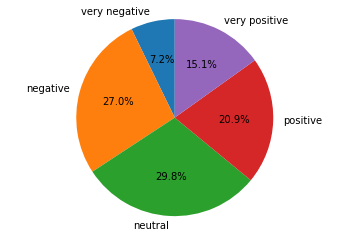

<Figure size 1440x720 with 0 Axes>

In [64]:
sen = la['sentiment']
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
sizes = [
    len(sen[la.sentiment == 'very negative']),
    len(sen[la.sentiment == 'negative']),
    len(sen[la.sentiment == 'neutral']),
    len(sen[la.sentiment == 'positive']),
    len(sen[la.sentiment == 'very positive'])
]
piec(sizes, labels)

### CATEGORY CLASSES

In [65]:
categories = collapse_category_labels(la['category'])
categories.unique()

array(['requirement', 'other', 'bug report'], dtype=object)

In [66]:
len(categories[categories == 'requirement'])

1087

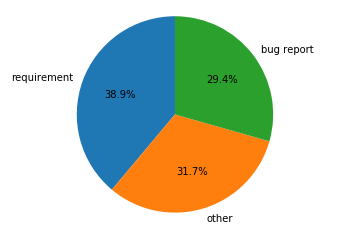

<Figure size 1440x720 with 0 Axes>

In [67]:
labels = ['requirement', 'other', 'bug report']
sizes = [
    len(categories[categories == 'requirement']),
    len(categories[categories == 'other']),
    len(categories[categories == 'bug report'])
]
piec(sizes, labels)

## CULTURE STUDY DATA

### SENTIMENT CLASSES

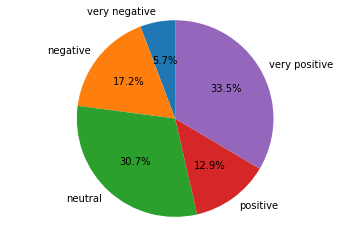

<Figure size 1440x720 with 0 Axes>

In [68]:
sen = l2['sentimentScore']
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
sizes = [
    len(sen[l2.sentimentScore == -2]),
    len(sen[l2.sentimentScore == -1]),
    len(sen[l2.sentimentScore == 0]),
    len(sen[l2.sentimentScore == 1]),
    len(sen[l2.sentimentScore == 2]),
]
piec(sizes, labels)

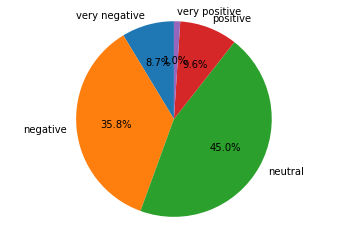

<Figure size 1440x720 with 0 Axes>

In [69]:
bug_reports = la[la.category == 'bug report']
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
sizes = []
for l in labels:
    sizes.append(len(bug_reports[bug_reports.sentiment == l]))
piec(sizes, labels)
# sentiment distribution in "bug report" reviews

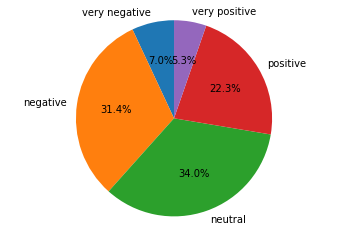

<Figure size 1440x720 with 0 Axes>

In [70]:
requirements = la[la.category == 'requirement']
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
sizes = []
for l in labels:
    sizes.append(len(requirements[requirements.sentiment == l]))

piec(sizes, labels)
# sentiment distribution in "requirement" reviews